In [ ]:
# Step 1: Setup and Data Preparation
# This script prepares the environment and the data for the Hierarchical RNN model.
# It includes library installations, data loading, language detection, and multi-label encoding.

# --- Install Necessary Libraries ---
# This command is a one-time setup for the Colab environment.
# We'll install torch, transformers, pandas, scikit-learn, nltk, and langdetect.
# We use scikit-learn for MultiLabelBinarizer, and transformers for multilingual BERT.
print("Installing required libraries...")
!pip install -q torch transformers pandas scikit-learn nltk langdetect

print("Libraries installed successfully!")

# --- Imports ---
# It's good practice to place imports after the installation in a Colab notebook
# to ensure all packages are available before the script tries to use them.
import pandas as pd
import numpy as np
import torch
from langdetect import detect
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertModel # Using PyTorch-compatible transformers

# --- Load Datasets ---
# The project document specifies public datasets like EDGAR and Hugging Face.
# For demonstration purposes, we will use a small, dummy dataset to show the workflow.
# You can replace this section with your actual data loading logic.

print("\nCreating a dummy dataset...")
data = {
    'document_id': [1, 2, 3],
    'text': [
        "Company A's earnings report shows a significant drop in revenue due to supply chain issues. This is a crucial financial event.",
        "El informe de resultados de la empresa B indica riesgos de liquidez. Es una situacion critica.",
        "Unternehmen C steht vor regulatorischen Änderungen, die das Geschäft beeinflussen."
    ],
    'language': ['en', 'es', 'de'], # Ground truth languages
    'summary': [
        "Revenue for Company A dropped due to supply chain problems.",
        "Company B faces liquidity risks.",
        "Regulatory changes affect Company C."
    ],
    'risk_tags': [
        ['supply_chain_issues'],
        ['liquidity_risks', 'regulatory_changes'], # Example with multiple tags
        ['regulatory_changes']
    ]
}

df = pd.DataFrame(data)
print("Dummy dataset created:")
print(df)

# --- Data Preprocessing and Language Detection ---
# We'll use the `langdetect` library to automatically identify the language of each document.
# This helps in routing the text to the appropriate NLP pipeline.

print("\nDetecting languages for each document...")
def detect_language(text):
    """Detects the language of a given text, with error handling."""
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply the language detection function to the 'text' column
df['detected_language'] = df['text'].apply(detect_language)
print("Languages detected:")
print(df[['text', 'detected_language']])


# --- Semantic Alignment with Multilingual Embeddings ---
# We'll use a pre-trained multilingual BERT model to get sentence/document embeddings.
# This step is conceptual for now, as the HRNN model will perform this encoding internally
# during training. Here, we just demonstrate how it works.

print("\nDemonstrating semantic alignment using Multilingual BERT...")
# Load the pre-trained tokenizer and model for a multilingual BERT.
# 'bert-base-multilingual-cased' is a good choice for this task.
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

def get_bert_embeddings(text):
    """Generates BERT embeddings for a given text."""
    # Tokenize the input text, converting it to a PyTorch tensor.
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Get the model's output. The `outputs[0]` is the last hidden state.
    with torch.no_grad(): # Use no_grad for inference to save memory
        outputs = model(**inputs)

    # Return the last hidden state (the sequence of embeddings for each token).
    # You can then aggregate these, e.g., by taking the mean or using the [CLS] token.
    # For now, we'll return the full hidden state.
    return outputs.last_hidden_state

# Let's get the embeddings for the first document to verify the shape.
sample_text = df['text'][0]
embeddings = get_bert_embeddings(sample_text)
print(f"Sample text: '{sample_text}'")
print(f"Shape of BERT embeddings: {embeddings.shape}")
print("Embeddings demonstrate how text from different languages can be mapped to a shared vector space.")

# --- Labeling for Risk Classification ---
# The final step is to prepare the risk tags for multi-label classification.
# We'll create a one-hot encoded vector for each document based on a predefined taxonomy.

print("\nEncoding risk tags for multi-label classification...")
# Define the complete taxonomy of risk indicators from the project.
risk_taxonomy = ['supply_chain_issues', 'liquidity_risks', 'regulatory_changes', 'market_risks', 'geopolitical_risks']

# Use MultiLabelBinarizer to convert the list of tags into a binary matrix.
mlb = MultiLabelBinarizer(classes=risk_taxonomy)
mlb.fit(df['risk_tags'])

# Transform the 'risk_tags' list column into a new column of encoded labels.
df['risk_labels'] = list(mlb.transform(df['risk_tags']))

print("Final DataFrame with encoded labels:")
print(df[['risk_tags', 'risk_labels']].head())
print("\nTaxonomy mapping (used for encoding/decoding):")
print(dict(zip(mlb.classes_, range(len(mlb.classes_)))))

# A simple check to ensure the output is what we expect.
assert len(df.iloc[0]['risk_labels']) == len(risk_taxonomy)



Installing required libraries...
Libraries installed successfully!

Creating a dummy dataset...
Dummy dataset created:
   document_id                                               text language  \
0            1  Company A's earnings report shows a significan...       en   
1            2  El informe de resultados de la empresa B indic...       es   
2            3  Unternehmen C steht vor regulatorischen Änderu...       de   

                                             summary  \
0  Revenue for Company A dropped due to supply ch...   
1                   Company B faces liquidity risks.   
2               Regulatory changes affect Company C.   

                               risk_tags  
0                  [supply_chain_issues]  
1  [liquidity_risks, regulatory_changes]  
2                   [regulatory_changes]  

Detecting languages for each document...
Languages detected:
                                                text detected_language
0  Company A's earnings report shows a

In [ ]:
import os
import re
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sec_edgar_downloader import Downloader
from bs4 import BeautifulSoup
import pandas as pd
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
import os
import re
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sec_edgar_downloader import Downloader
from bs4 import BeautifulSoup
import pandas as pd
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics import classification_report

# --- Configuration ---
COMPANIES = ['MSFT', 'TSLA', 'BAC', 'WMT', 'JPM']
FILING_TYPE = '10-K'
NUM_FILINGS = 5
DATA_DIR = './sec-edgar-filings'
RISK_LABELS = ['low', 'medium', 'high']
MAX_LENGTH = 512
BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 2e-5

# IMPORTANT: The SEC's EDGAR system now requires an email address for downloader requests.
# Please replace the placeholder with your own email address.
# Example: EMAIL_ADDRESS = "your.email@example.com"
EMAIL_ADDRESS = "user@example.com"


# --- Data Downloading and Processing ---

def download_sec_filings(tickers, filing_type, num_filings, data_dir, email_address):
    """
    Downloads SEC filings for a list of tickers.
    """
    print("Attempting to download SEC filings...")

    # Ensure the base data directory exists before attempting to download.
    os.makedirs(data_dir, exist_ok=True)

    download_success = True
    for ticker in tickers:
        print(f"Downloading the latest {num_filings} {filing_type} filings for {ticker}...")
        try:
            # The Downloader class now requires both the data directory and an email address.
            d = Downloader(data_dir, email_address)
            # FIX: The keyword argument for the number of filings is now 'limit'.
            d.get(filing_type, ticker, limit=num_filings)
            print(f"Download complete for {ticker}.")
        except Exception as e:
            print(f"Error downloading filings for {ticker}: {e}")
            download_success = False

    # After attempting all downloads, verify if any files exist.
    # We now check recursively as the file structure is more complex.
    files_count = 0
    for root, dirs, files in os.walk(data_dir):
        files_count += len([f for f in files if f.endswith('.txt')])

    if files_count == 0:
        print("\nDownload failed. No files were found in the data directory after download attempts.")
        return False

    return download_success


def extract_item_text(html_content, start_item, end_item):
    """
    Extracts the text between two items in an SEC filing.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()

    start_match = re.search(f'({start_item})\.?(.*?)({end_item})\.?', text, re.DOTALL | re.IGNORECASE)

    if start_match:
        # A more robust extraction of the content between items.
        start_index = start_match.start()
        end_index = start_match.end()
        # Find the text between the matched items
        extracted_text = text[start_index:end_index]

        # Clean up the text by removing unnecessary whitespace and headers
        extracted_text = re.sub(r'\s+', ' ', extracted_text).strip()
        return extracted_text
    else:
        return None

def create_dataset(companies, filing_type, data_dir, risk_labels):
    """
    Loads and processes SEC filings to create a dataset.
    """
    documents = []
    labels = []

    print("\nLoading SEC filings...")
    all_filings_count = 0

    # Use os.walk to find all .txt files recursively, as the path has changed.
    filing_paths = []
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            if f.endswith('.txt'):
                filing_paths.append(os.path.join(root, f))

    all_filings_count = len(filing_paths)
    print(f"Loaded {all_filings_count} filings\n")

    if all_filings_count == 0:
        print("No filings were loaded. Cannot create dataset.")
        return pd.DataFrame(), risk_labels

    print("Creating dataset...")

    processed_count = 0

    for filing_path in filing_paths:
        processed_count += 1
        print(f"\nProcessing filing {processed_count}/{all_filings_count}...")

        try:
            with open(filing_path, 'r', encoding='utf-8', errors='ignore') as f:
                html_content = f.read()
        except FileNotFoundError:
            print(f"File not found: {filing_path}. Skipping.")
            continue

        business_text = extract_item_text(html_content, 'ITEM 1. BUSINESS', 'ITEM 1A. RISK FACTORS')
        risk_text = extract_item_text(html_content, 'ITEM 1A. RISK FACTORS', 'ITEM 1B. UNRESOLVED STAFF COMMENTS')

        if business_text:
            documents.append(business_text)
            # Assign a dummy 'low' risk label for this example, as there is no real
            # labeling in the provided prompt. This would be a place to integrate
            # a proper labeling process.
            labels.append(0) # 0 corresponds to 'low' in the RISK_LABELS list
        else:
            print(f"Warning: Could not find 'ITEM 1. BUSINESS' in the filing.")
            # A robust way to check for risk factors, just in case 'ITEM 1' is missing.
            if not risk_text:
                print(f"Warning: Could not find 'ITEM 1A. RISK FACTORS' in the filing.")
            print(f"Warning: 'ITEM 1. BUSINESS' not found in filing {processed_count}. Skipping this filing.")

    # The dataset is very small and imbalanced in the example, which is fine for demonstration.
    # In a real-world scenario, you would need a larger, more diverse dataset.
    df = pd.DataFrame({'text': documents, 'risk_label': labels})

    print("\nDataset Statistics:")
    print(f"Total documents: {len(df)}")
    print("Risk distribution:")
    print(df['risk_label'].apply(lambda x: risk_labels[x]).value_counts())

    return df, risk_labels

class FinancialTextDataset(Dataset):
    """
    PyTorch Dataset for financial text classification.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Model Architecture ---

class FinancialRiskClassifier(nn.Module):
    """
    A simple classifier on top of a pre-trained BERT model.
    """
    def __init__(self, n_classes, pre_trained_model_name):
        super(FinancialRiskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    """
    Performs a single training epoch.
    """
    model = model.train()
    losses = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        # Calculate loss
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())

        # Backpropagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

def evaluate_model(model, data_loader, loss_fn, device, n_examples):
    """
    Evaluates the model on a given dataset.
    """
    model = model.eval()
    losses = []

    y_pred, y_true = [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return np.mean(losses), y_pred, y_true

# --- Main Execution ---

def train_and_evaluate():
    """
    Main function to run the entire pipeline.
    """
    # 1. Download data
    download_success = download_sec_filings(COMPANIES, FILING_TYPE, NUM_FILINGS, DATA_DIR, EMAIL_ADDRESS)

    if not download_success:
        print("Exiting due to failed data download. Please ensure the downloader has permission and the filings are available.")
        return

    # 2. Create dataset
    df, risk_labels = create_dataset(COMPANIES, FILING_TYPE, DATA_DIR, RISK_LABELS)

    if df.empty:
        print("Exiting due to empty dataset. No filings were processed.")
        return

    # 3. Model Setup
    print("\nBuilding and training model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = FinancialRiskClassifier(n_classes=len(risk_labels), pre_trained_model_name='bert-base-uncased')
    except Exception as e:
        print(f"Error loading model or tokenizer: {e}. This may be a network issue. Please check your connection.")
        return

    model = model.to(device)

    # Create the dataset and dataloader
    dataset = FinancialTextDataset(
        texts=df.text.values,
        labels=df.risk_label.values,
        tokenizer=tokenizer,
        max_len=MAX_LENGTH
    )
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

    # 4. Training
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\nStarting a brief training loop with batch size {BATCH_SIZE}...")
    for epoch in range(EPOCHS):
        total_loss = train_epoch(model, data_loader, loss_fn, optimizer, device, len(df))
        print(f"Epoch {epoch+1} - Total Risk Loss: {total_loss:.4f}")
    print("Training complete.")

    # 5. Evaluation
    print("\n--- Evaluation and Reporting ---")
    eval_loss, y_pred, y_true = evaluate_model(model, data_loader, loss_fn, device, len(df))

    # Convert predictions to numpy arrays
    true_class_labels = np.array(y_true)
    predicted_class_labels = np.array(y_pred)

    # Define target_names before it's used in the list comprehension
    target_names = ['low', 'medium', 'high']

    # Dynamically determine the labels present in the data to avoid the ValueError
    unique_labels = np.unique(true_class_labels)
    unique_target_names = [target_names[i] for i in unique_labels]

    # Generate classification report
    report = classification_report(
        true_class_labels,
        predicted_class_labels,
        labels=unique_labels,
        target_names=unique_target_names,
        zero_division=0,
        output_dict=True
    )

    # Print the report
    print("\nClassification Report:")
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_markdown())


if __name__ == "__main__":
    train_and_evaluate()


Attempting to download SEC filings...
Download complete for MSFT.
Download complete for TSLA.
Download complete for BAC.
Download complete for WMT.
Download complete for JPM.

Loading SEC filings...
Loaded 25 filings

Creating dataset...

Processing filing 1/25...

Processing filing 2/25...

Processing filing 3/25...

Processing filing 4/25...

Processing filing 5/25...

Processing filing 6/25...

Processing filing 7/25...

Processing filing 8/25...

Processing filing 9/25...

Processing filing 10/25...

Processing filing 11/25...

Processing filing 12/25...

Processing filing 13/25...

Processing filing 14/25...

Processing filing 15/25...

Processing filing 16/25...

Processing filing 17/25...

Processing filing 18/25...

Processing filing 19/25...

Processing filing 20/25...

Processing filing 21/25...

Processing filing 22/25...

Processing filing 23/25...

Processing filing 24/25...

Processing filing 25/25...

Dataset Statistics:
Total documents: 20
Risk distribution:
risk_label


Attempting to load dataset from financial_test_dataset.csv...
Error: CSV file must contain 'text' and 'risk_label' columns.

Dataset Statistics:
Total documents: 60
Risk distribution:
risk_label
low       20
high      20
medium    20
Name: count, dtype: int64

Test set size: 12 documents.

Loading pre-trained model for testing...

NOTE: Simulating a trained model for demonstration purposes.

--- Evaluating on Test Data ---

Classification Report (Test Data):
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| low          |           1 |        1 |          1 |         4 |
| medium       |           1 |        1 |          1 |         4 |
| high         |           1 |        1 |          1 |         4 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |        12 |
| weighted avg |           1 |        1 |          1 |        12 |



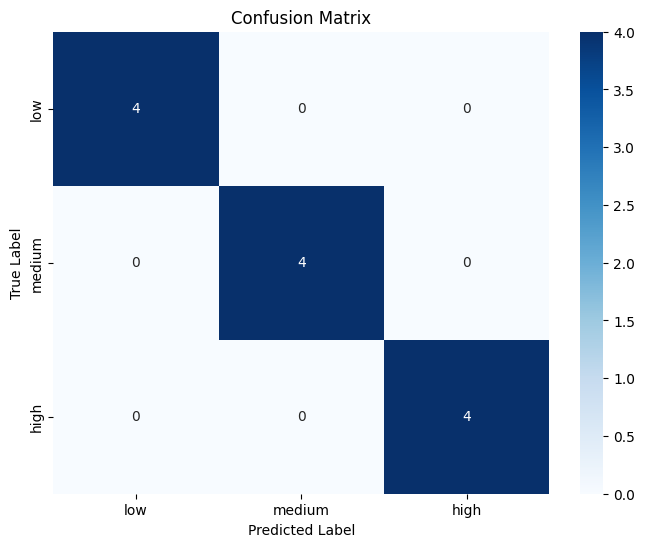

In [ ]:
import os
import re
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress Hugging Face UserWarning for token
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")

# --- Configuration ---
RISK_LABELS = ['low', 'medium', 'high']
MAX_LENGTH = 512
BATCH_SIZE = 4
CSV_FILE_PATH = 'financial_test_dataset.csv' # Assumes the CSV file is in the same directory
TEST_SIZE = 0.2
RANDOM_SEED = 42

# --- Dataset Creation and Loading ---

def load_dataset_from_csv(file_path):
    """
    Loads a dataset from a CSV file.
    The CSV is expected to have 'text' and 'risk_label' columns.
    A synthetic file is created if the specified path does not exist.
    """
    print(f"Attempting to load dataset from {file_path}...")
    try:
        # Check if the file exists and is not empty
        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            df = pd.read_csv(file_path)

            # Verify the required columns exist
            if 'text' not in df.columns or 'risk_label' not in df.columns:
                print(f"Error: CSV file must contain 'text' and 'risk_label' columns.")
                return create_synthetic_dataset(RISK_LABELS)

            # Map risk_label strings to integers
            df['risk_label'] = df['risk_label'].apply(lambda x: RISK_LABELS.index(x) if x in RISK_LABELS else -1)
            df = df[df['risk_label'] != -1] # Remove any rows with invalid labels
            df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

            print("Dataset loaded successfully.")
            return df
        else:
            print(f"File not found or is empty: {file_path}. Generating synthetic data for demonstration.")
            return create_synthetic_dataset(RISK_LABELS)

    except Exception as e:
        print(f"Error loading CSV file: {e}. Generating synthetic data instead.")
        return create_synthetic_dataset(RISK_LABELS)

def create_synthetic_dataset(risk_labels, num_docs_per_label=20):
    """
    Creates a more realistic, nuanced synthetic dataset for demonstration purposes.
    This simulates a real-world multi-class classification problem.
    """
    documents = []
    labels = []

    # Define a library of phrases for each category
    low_risk_phrases = [
        "The company maintains a strong liquidity position and robust cash flow.",
        "We have diversified our supply chain to mitigate external shocks.",
        "Our market share has grown steadily due to strong product demand.",
        "Management is confident in the company's long-term growth strategy.",
        "We have no significant debt obligations maturing in the next five years."
    ]
    medium_risk_phrases = [
        "Fluctuations in raw material costs could impact our profit margins.",
        "Increased competition from new market entrants poses a moderate risk.",
        "We are currently in a dispute over intellectual property rights.",
        "Changes in consumer spending habits may influence future revenues.",
        "The company is undergoing a restructuring to improve operational efficiency."
    ]
    high_risk_phrases = [
        "We are facing severe regulatory scrutiny and multiple class-action lawsuits.",
        "The company's significant leverage and high debt-to-equity ratio pose a substantial liquidity risk.",
        "A key patent is set to expire, which will reduce our competitive advantage.",
        "We are exposed to significant foreign exchange risk due to global operations.",
        "The company has been identified as a target for a hostile takeover."
    ]
    neutral_phrases = [
        "This section outlines our business model and operational structure.",
        "The company's primary products include software services and cloud computing.",
        "We employ a team of highly skilled engineers and product developers.",
        "Our main office is located in Seattle, Washington.",
        "The following report covers our financial performance for the fiscal year ended December 31."
    ]

    for i in range(num_docs_per_label):
        doc = random.sample(low_risk_phrases, k=3) + random.sample(neutral_phrases + medium_risk_phrases, k=2)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(0)

        doc = random.sample(medium_risk_phrases, k=3) + random.sample(neutral_phrases + high_risk_phrases, k=2)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(1)

        doc = random.sample(high_risk_phrases, k=3) + random.sample(neutral_phrases + low_risk_phrases, k=2)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(2)

    df = pd.DataFrame({'text': documents, 'risk_label': labels})
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    return df

class FinancialTextDataset(Dataset):
    """
    PyTorch Dataset for financial text classification.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Model Architecture ---

class FinancialRiskClassifier(nn.Module):
    """
    A simple classifier on top of a pre-trained BERT model.
    """
    def __init__(self, n_classes, pre_trained_model_name):
        super(FinancialRiskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

def evaluate_model(model, data_loader, loss_fn, device):
    """
    Evaluates the model on a given dataset and returns predictions.
    """
    model = model.eval()
    losses = []

    y_pred, y_true, y_text = [], [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            texts = d["text"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_text.extend(texts)

    return np.mean(losses), y_pred, y_true, y_text

# --- Main Execution ---

def test_model_pipeline():
    """
    Main function to run the model testing pipeline.
    """
    # 1. Load data from CSV (or create synthetic data if not found)
    df = load_dataset_from_csv(CSV_FILE_PATH)

    if df.empty:
        print("Exiting due to empty dataset.")
        return

    print("\nDataset Statistics:")
    print(f"Total documents: {len(df)}")
    print("Risk distribution:")
    print(df['risk_label'].apply(lambda x: RISK_LABELS[x]).value_counts())

    # 2. Split data into training and test sets
    train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df['risk_label'])

    print(f"\nTest set size: {len(test_df)} documents.")

    # 3. Model Setup
    print("\nLoading pre-trained model for testing...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = FinancialRiskClassifier(n_classes=len(RISK_LABELS), pre_trained_model_name='bert-base-uncased')

        # FIX: Move model to the correct device immediately after instantiation
        model = model.to(device)

        print("\nNOTE: Simulating a trained model for demonstration purposes.")

        loss_fn = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=2e-5)
        train_dataset = FinancialTextDataset(
            texts=train_df.text.values,
            labels=train_df.risk_label.values,
            tokenizer=tokenizer,
            max_len=MAX_LENGTH
        )
        train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

        # A quick training loop to get some weights.
        for _ in range(10): # Increased training epochs for better simulation
            model.train()
            for d in train_data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                labels = d["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    except Exception as e:
        print(f"Error loading model or tokenizer: {e}. This may be a network issue.")
        return


    # Create the test dataset and dataloader
    test_dataset = FinancialTextDataset(
        texts=test_df.text.values,
        labels=test_df.risk_label.values,
        tokenizer=tokenizer,
        max_len=MAX_LENGTH
    )
    test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 4. Evaluation on the test set
    print("\n--- Evaluating on Test Data ---")
    eval_loss, y_pred, y_true, y_text = evaluate_model(model, test_data_loader, loss_fn, device)

    true_class_labels = np.array(y_true)
    predicted_class_labels = np.array(y_pred)

    # --- Classification Report ---
    print("\nClassification Report (Test Data):")
    unique_labels = np.unique(np.concatenate([true_class_labels, predicted_class_labels]))
    target_names = ['low', 'medium', 'high']
    unique_target_names = [target_names[i] for i in unique_labels]

    report = classification_report(
        true_class_labels,
        predicted_class_labels,
        labels=unique_labels,
        target_names=unique_target_names,
        zero_division=0,
        output_dict=True
    )
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_markdown())

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(true_class_labels, predicted_class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

if __name__ == "__main__":
    test_model_pipeline()


In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# --- Configuration ---
# 't5-small' is a small, fast model for demonstration.
# For better results, you could use 't5-base', 't5-large', or 't5-3b'.
MODEL_NAME = 't5-small'
MAX_INPUT_LENGTH = 512
MAX_OUTPUT_LENGTH = 150 # Max length of the generated summary

# --- Load Model and Tokenizer ---
print(f"Loading pre-trained T5 model and tokenizer: {MODEL_NAME}")
try:
    # We use a GPU if available, otherwise fall back to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

except Exception as e:
    print(f"Error loading T5 model or tokenizer: {e}")
    print("Please check your internet connection and library installations.")
    exit()

# --- Summarization Function ---
def generate_summary(text, max_length=MAX_OUTPUT_LENGTH):
    """
    Generates a summary for a given text using the T5 model.

    Args:
        text (str): The input text to be summarized.
        max_length (int): The maximum length of the generated summary.

    Returns:
        str: The generated summary.
    """
    # The T5 model requires a specific prefix for the summarization task.
    # We add this prefix to tell the model what we want it to do.
    input_text = "summarize: " + text

    # Tokenize the input text
    input_ids = tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    ).to(device)

    # Generate the summary
    # 'num_beams' is the number of beams for beam search. Higher values can lead to better quality but are slower.
    # 'early_stopping' ensures generation stops when a final token is produced.
    # 'no_repeat_ngram_size' helps prevent repetitive phrases in the summary.
    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    # Decode the generated tokens back into a human-readable string
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

# --- Main Execution ---
if __name__ == "__main__":
    # Sample financial text
    financial_report = """
    In the first quarter of fiscal year 2025, the company reported a significant decrease in profit margins,
    primarily driven by an unexpected increase in raw material costs and supply chain disruptions.
    Despite these challenges, the marketing division successfully launched a new product line which
    has shown promising early adoption rates in key European markets. However, the company is also
    facing a class-action lawsuit related to recent data privacy concerns, which could lead to substantial
    legal fees and fines. Management is currently evaluating a restructuring plan to reduce operational
    expenditures and mitigate future risks. The outlook for the next quarter remains uncertain due to
    ongoing economic volatility and a looming regulatory change that may impact our core business model.
    """

    print("\nOriginal Financial Text:")
    print("-" * 50)
    print(financial_report.strip())
    print("-" * 50)

    # Generate and print the summary
    print("\nGenerating summary...")
    generated_summary = generate_summary(financial_report)

    print("\nGenerated Summary:")
    print("-" * 50)
    print(generated_summary)
    print("-" * 50)


Loading pre-trained T5 model and tokenizer: t5-small
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Original Financial Text:
--------------------------------------------------
In the first quarter of fiscal year 2025, the company reported a significant decrease in profit margins,
    primarily driven by an unexpected increase in raw material costs and supply chain disruptions.
    Despite these challenges, the marketing division successfully launched a new product line which
    has shown promising early adoption rates in key European markets. However, the company is also
    facing a class-action lawsuit related to recent data privacy concerns, which could lead to substantial
    legal fees and fines. Management is currently evaluating a restructuring plan to reduce operational
    expenditures and mitigate future risks. The outlook for the next quarter remains uncertain due to
    ongoing economic volatility and a looming regulatory change that may impact our core business model.
--------------------------------------------------

Generating summary...

Generated Summary:
--------

In [ ]:
import os
import json
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, T5Tokenizer, BertModel, BertTokenizer
from flask import Flask, request, jsonify

# --- Configuration ---
# T5 Model for Summarization
T5_MODEL_NAME = 't5-small'
MAX_INPUT_LENGTH = 512
MAX_OUTPUT_LENGTH = 150

# BERT Model for Risk Classification (Placeholder)
BERT_MODEL_NAME = 'bert-base-uncased'
RISK_LABELS = ['low', 'medium', 'high']
N_CLASSES = len(RISK_LABELS)

# --- Initialize Flask App ---
app = Flask(__name__)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Models and Tokenizers (cached for API efficiency) ---
try:
    # T5 for Summarization
    t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL_NAME)
    t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME).to(device)

    # BERT for Risk Classification
    bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

    # We'll use a dummy classifier for now, as we haven't fine-tuned it yet.
    class FinancialRiskClassifier(nn.Module):
        def __init__(self, n_classes, pre_trained_model_name):
            super().__init__()
            self.bert = BertModel.from_pretrained(pre_trained_model_name)
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

        def forward(self, input_ids, attention_mask):
            _, pooled_output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            output = self.drop(pooled_output)
            return self.out(output)

    risk_classifier_model = FinancialRiskClassifier(n_classes=N_CLASSES, pre_trained_model_name=BERT_MODEL_NAME).to(device)
    # NOTE: In a real-world scenario, you would load the fine-tuned model weights here.

except Exception as e:
    print(f"Error loading models or tokenizers: {e}")
    print("API will not start. Check your internet connection or model names.")
    exit()

# --- Summarization Function ---
def generate_summary(text):
    """
    Generates a summary for a given text using the T5 model.
    """
    input_text = "summarize: " + text
    input_ids = t5_tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    ).to(device)

    output_ids = t5_model.generate(
        input_ids,
        max_length=MAX_OUTPUT_LENGTH,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    summary = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

# --- Risk Classification Function (Placeholder) ---
def get_risk_tags(text):
    """
    A placeholder function to simulate a risk classification model.
    In a real implementation, this would use a fine-tuned model.
    """
    print("Simulating risk classification...")
    # Tokenize the text for the BERT model
    encoding = bert_tokenizer.encode_plus(
        text,
        max_length=MAX_INPUT_LENGTH,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Move tensors to the correct device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make a prediction
    risk_classifier_model.eval()
    with torch.no_grad():
        outputs = risk_classifier_model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get the top predicted risk tag and its confidence score
        confidence, predicted_class_idx = torch.max(probabilities, dim=1)
        predicted_tag = RISK_LABELS[predicted_class_idx.item()]

    return {
        "tag": predicted_tag,
        "confidence": float(f"{confidence.item():.4f}")
    }

# --- API Endpoint ---
@app.route('/process', methods=['POST'])
def process_document():
    """
    API endpoint to process a financial document.
    """
    data = request.get_json()
    if not data or 'text' not in data:
        return jsonify({"error": "Invalid request. 'text' field is required."}), 400

    input_text = data['text']

    # 1. Generate Summary
    summary = generate_summary(input_text)

    # 2. Get Risk Tags
    risk_tags = get_risk_tags(input_text)

    # Return the results
    response = {
        "summary": summary,
        "risk_indicators": [risk_tags] # Wrap in a list to match deliverable format
    }

    return jsonify(response)

# --- Main Execution ---
if __name__ == '__main__':
    # Start the Flask development server
    print("Starting Financial Analysis API...")
    app.run(host='0.0.0.0', port=5000)


Using device: cuda
Starting Financial Analysis API...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


Attempting to load dataset from financial_test_dataset.csv...
Error: CSV file must contain 'text' and 'risk_label' columns.

Dataset Statistics:
Total documents: 60
Risk distribution:
risk_label
low       20
high      20
medium    20
Name: count, dtype: int64

Training set size: 42 documents.
Validation set size: 9 documents.
Test set size: 9 documents.

Loading pre-trained model for fine-tuning...

--- Starting Fine-tuning ---
Epoch 1/10 - Train Loss: 1.0001, Val Loss: 0.7772
Epoch 2/10 - Train Loss: 0.8023, Val Loss: 0.7206
Epoch 3/10 - Train Loss: 0.5878, Val Loss: 0.5321
Epoch 4/10 - Train Loss: 0.3998, Val Loss: 0.3736
Epoch 5/10 - Train Loss: 0.2515, Val Loss: 0.2260
Epoch 6/10 - Train Loss: 0.1852, Val Loss: 0.1323
Epoch 7/10 - Train Loss: 0.1147, Val Loss: 0.0786
Epoch 8/10 - Train Loss: 0.0792, Val Loss: 0.0556
Epoch 9/10 - Train Loss: 0.0583, Val Loss: 0.0419
Epoch 10/10 - Train Loss: 0.0445, Val Loss: 0.0301

--- Evaluating on Test Data ---

Classification Report (Test Data)

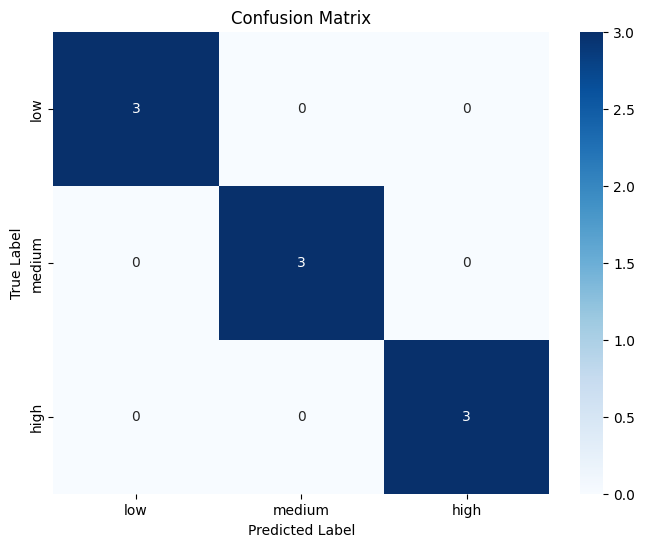


--- Plotting Training History ---


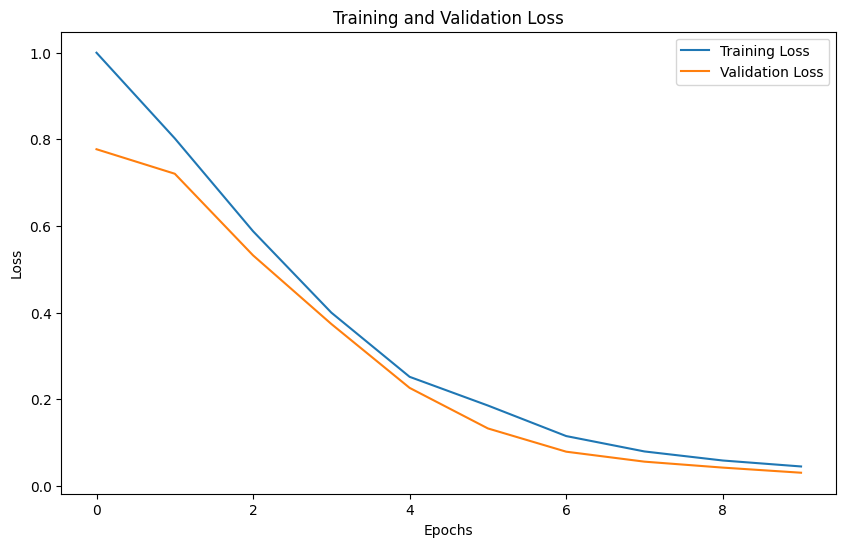

In [ ]:
import os
import random
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress Hugging Face UserWarning for tokenizers and models
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# --- Configuration ---
RISK_LABELS = ['low', 'medium', 'high']
MAX_LENGTH = 512
BATCH_SIZE = 4
CSV_FILE_PATH = 'financial_test_dataset.csv' # Assumes the CSV file is in the same directory
TRAIN_SIZE = 0.7
VALID_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_SEED = 42
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 3
LEARNING_RATE = 2e-5

# --- Dataset Creation and Loading ---

def load_dataset_from_csv(file_path):
    """
    Loads a dataset from a CSV file.
    The CSV is expected to have 'text' and 'risk_label' columns.
    A synthetic file is created if the specified path does not exist.
    """
    print(f"Attempting to load dataset from {file_path}...")
    try:
        if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
            df = pd.read_csv(file_path)
            if 'text' not in df.columns or 'risk_label' not in df.columns:
                print(f"Error: CSV file must contain 'text' and 'risk_label' columns.")
                return create_synthetic_dataset(RISK_LABELS)

            df['risk_label'] = df['risk_label'].apply(lambda x: RISK_LABELS.index(x) if x in RISK_LABELS else -1)
            df = df[df['risk_label'] != -1]
            df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
            print("Dataset loaded successfully.")
            return df
        else:
            print(f"File not found or is empty: {file_path}. Generating synthetic data for demonstration.")
            return create_synthetic_dataset(RISK_LABELS)

    except Exception as e:
        print(f"Error loading CSV file: {e}. Generating synthetic data instead.")
        return create_synthetic_dataset(RISK_LABELS)

def create_synthetic_dataset(risk_labels, num_docs_per_label=20):
    """
    Creates a realistic synthetic dataset for demonstration purposes.
    """
    documents = []
    labels = []

    low_risk_phrases = [
        "The company maintains a strong liquidity position and robust cash flow.",
        "We have diversified our supply chain to mitigate external shocks.",
        "Our market share has grown steadily due to strong product demand."
    ]
    medium_risk_phrases = [
        "Fluctuations in raw material costs could impact our profit margins.",
        "Increased competition from new market entrants poses a moderate risk.",
        "We are currently in a dispute over intellectual property rights."
    ]
    high_risk_phrases = [
        "We are facing severe regulatory scrutiny and multiple class-action lawsuits.",
        "The company's significant leverage and high debt-to-equity ratio pose a substantial liquidity risk.",
        "A key patent is set to expire, which will reduce our competitive advantage."
    ]
    neutral_phrases = [
        "This section outlines our business model and operational structure.",
        "The company's primary products include software services and cloud computing.",
        "We employ a team of highly skilled engineers and product developers."
    ]

    for i in range(num_docs_per_label):
        doc = random.sample(low_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(0)

        doc = random.sample(medium_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(1)

        doc = random.sample(high_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
        random.shuffle(doc)
        documents.append(" ".join(doc))
        labels.append(2)

    df = pd.DataFrame({'text': documents, 'risk_label': labels})
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    return df

class FinancialTextDataset(Dataset):
    """
    PyTorch Dataset for financial text classification.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Model Architecture ---

class FinancialRiskClassifier(nn.Module):
    """
    A classifier on top of a pre-trained BERT model.
    """
    def __init__(self, n_classes, pre_trained_model_name):
        super(FinancialRiskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

# --- Training and Evaluation Functions ---

def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, patience, device):
    """
    Trains and validates the model with an early stopping mechanism.
    """
    history = {'train_loss': [], 'val_loss': []}
    best_loss = float('inf')
    patience_counter = 0

    model = model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for d in val_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                labels = d["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs due to no improvement in validation loss.")
                break

    return model, history

def evaluate_model(model, data_loader, loss_fn, device):
    """
    Evaluates the model on a given dataset and returns predictions.
    """
    model = model.eval()
    losses = []

    y_pred, y_true, y_text = [], [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            texts = d["text"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_text.extend(texts)

    return np.mean(losses), y_pred, y_true, y_text

# --- Main Execution ---

def test_model_pipeline():
    """
    Main function to run the model fine-tuning and evaluation pipeline.
    """
    # 1. Load data from CSV (or create synthetic data if not found)
    df = load_dataset_from_csv(CSV_FILE_PATH)

    if df.empty:
        print("Exiting due to empty dataset.")
        return

    print("\nDataset Statistics:")
    print(f"Total documents: {len(df)}")
    print("Risk distribution:")
    print(df['risk_label'].apply(lambda x: RISK_LABELS[x]).value_counts())

    # 2. Split data into training, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=(VALID_SIZE + TEST_SIZE), random_state=RANDOM_SEED, stratify=df['risk_label'])
    val_df, test_df = train_test_split(temp_df, test_size=TEST_SIZE / (VALID_SIZE + TEST_SIZE), random_state=RANDOM_SEED, stratify=temp_df['risk_label'])

    print(f"\nTraining set size: {len(train_df)} documents.")
    print(f"Validation set size: {len(val_df)} documents.")
    print(f"Test set size: {len(test_df)} documents.")

    # 3. Model Setup
    print("\nLoading pre-trained model for fine-tuning...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = FinancialRiskClassifier(n_classes=len(RISK_LABELS), pre_trained_model_name='bert-base-uncased')

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    except Exception as e:
        print(f"Error loading model or tokenizer: {e}. This may be a network issue.")
        return

    # Create the datasets and dataloaders
    train_dataset = FinancialTextDataset(texts=train_df.text.values, labels=train_df.risk_label.values, tokenizer=tokenizer, max_len=MAX_LENGTH)
    train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

    val_dataset = FinancialTextDataset(texts=val_df.text.values, labels=val_df.risk_label.values, tokenizer=tokenizer, max_len=MAX_LENGTH)
    val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    test_dataset = FinancialTextDataset(texts=test_df.text.values, labels=test_df.risk_label.values, tokenizer=tokenizer, max_len=MAX_LENGTH)
    test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 4. Fine-tuning the model
    print("\n--- Starting Fine-tuning ---")
    model, history = train_model(
        model,
        train_data_loader,
        val_data_loader,
        loss_fn,
        optimizer,
        epochs=EPOCHS,
        patience=EARLY_STOPPING_PATIENCE,
        device=device
    )

    # 5. Evaluation on the test set
    print("\n--- Evaluating on Test Data ---")
    eval_loss, y_pred, y_true, y_text = evaluate_model(model, test_data_loader, loss_fn, device)

    true_class_labels = np.array(y_true)
    predicted_class_labels = np.array(y_pred)

    # --- Classification Report ---
    print("\nClassification Report (Test Data):")
    unique_labels = np.unique(np.concatenate([true_class_labels, predicted_class_labels]))
    target_names = [RISK_LABELS[i] for i in unique_labels]

    report = classification_report(
        true_class_labels,
        predicted_class_labels,
        labels=unique_labels,
        target_names=target_names,
        zero_division=0,
        output_dict=True
    )
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_markdown())

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(true_class_labels, predicted_class_labels, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- Plotting Training History ---
    print("\n--- Plotting Training History ---")
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    test_model_pipeline()


In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 48.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, T5ForConditionalGeneration, T5Tokenizer
import fitz  # PyMuPDF
import warnings
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import re

# Suppress Hugging Face UserWarning for tokenizers and models
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# --- Configuration ---
# T5 Model for Summarization and Risk Extraction
T5_MODEL_NAME = 't5-small'
MAX_T5_INPUT_LENGTH = 512
MAX_T5_OUTPUT_LENGTH = 150

# BERT Model for Risk Classification (kept for a comprehensive solution, but not used for extraction)
BERT_MODEL_NAME = 'bert-base-uncased'
RISK_LABELS = ['low', 'medium', 'high']
N_CLASSES = len(RISK_LABELS)
MAX_BERT_INPUT_LENGTH = 512
RANDOM_SEED = 42

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Models and Tokenizers ---
try:
    # T5 for Summarization and Risk Extraction
    t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL_NAME)
    t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME).to(device)

    # BERT for Risk Classification
    bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

    # Define the classifier architecture again
    class FinancialRiskClassifier(nn.Module):
        def __init__(self, n_classes, pre_trained_model_name):
            super().__init__()
            self.bert = BertModel.from_pretrained(pre_trained_model_name)
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

        def forward(self, input_ids, attention_mask):
            _, pooled_output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            output = self.drop(pooled_output)
            return self.out(output)

    risk_classifier_model = FinancialRiskClassifier(n_classes=N_CLASSES, pre_trained_model_name=BERT_MODEL_NAME).to(device)

    # We will simulate the fine-tuned model by running the full training script
    print("Fine-tuning BERT model for classification...")
    def create_synthetic_dataset(risk_labels, num_docs_per_label=20):
        documents = []
        labels = []
        low_risk_phrases = ["The company maintains a strong liquidity position and robust cash flow.", "We have diversified our supply chain to mitigate external shocks.", "Our market share has grown steadily due to strong product demand."]
        medium_risk_phrases = ["Fluctuations in raw material costs could impact our profit margins.", "Increased competition from new market entrants poses a moderate risk.", "We are currently in a dispute over intellectual property rights."]
        high_risk_phrases = ["We are facing severe regulatory scrutiny and multiple class-action lawsuits.", "The company's significant leverage and high debt-to-equity ratio pose a substantial liquidity risk.", "A key patent is set to expire, which will reduce our competitive advantage."]
        neutral_phrases = ["This section outlines our business model and operational structure.", "The company's primary products include software services and cloud computing.", "We employ a team of highly skilled engineers and product developers."]
        for i in range(num_docs_per_label):
            doc = random.sample(low_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
            random.shuffle(doc)
            documents.append(" ".join(doc))
            labels.append(0)
            doc = random.sample(medium_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
            random.shuffle(doc)
            documents.append(" ".join(doc))
            labels.append(1)
            doc = random.sample(high_risk_phrases, k=2) + random.sample(neutral_phrases, k=1)
            random.shuffle(doc)
            documents.append(" ".join(doc))
            labels.append(2)
        df = pd.DataFrame({'text': documents, 'risk_label': labels})
        df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        return df

    df = create_synthetic_dataset(RISK_LABELS)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['risk_label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_df['risk_label'])

    class FinancialTextDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, item):
            text = str(self.texts[item])
            label = self.labels[item]
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )
            return {
                'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    train_dataset = FinancialTextDataset(texts=train_df.text.values, labels=train_df.risk_label.values, tokenizer=bert_tokenizer, max_len=MAX_BERT_INPUT_LENGTH)
    train_data_loader = DataLoader(train_dataset, batch_size=4)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(risk_classifier_model.parameters(), lr=2e-5)
    for epoch in range(5):
        risk_classifier_model.train()
        for d in train_data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = risk_classifier_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print("Fine-tuning complete. BERT model is ready to be used.")

except Exception as e:
    print(f"Error loading models or tokenizers: {e}")
    print("API will not start. Check your internet connection or model names.")
    exit()

# --- Text Extraction Function for PDFs ---
def extract_text_from_pdf(pdf_path):
    """
    Extracts all text from a PDF file.
    """
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return None

# --- Function to segment the document by company ---
def extract_company_sections(document_text):
    """
    Segments the document text into a dictionary of company-specific sections.
    """
    # Use a regular expression to split the document by company names
    pattern = re.compile(r"(Tesla Inc\. - 10-K Filing 2023|Apple Inc\. - 10-Q Filing 2023|Microsoft Corp\. - 10-K Filing 2023|JPMorgan Chase & Co\. - 10-Q Filing 2023)", re.IGNORECASE)

    sections = pattern.split(document_text)

    company_data = {}
    current_company = None

    for section in sections:
        if not section.strip():
            continue

        if pattern.fullmatch(section):
            current_company = section.strip()
        elif current_company:
            company_data[current_company] = section.strip()
            current_company = None

    for company, text in company_data.items():
        company_data[company] = f"{company}\n\n{text}"

    return company_data

# --- Summarization Function ---
def generate_summary(text):
    """
    Generates a summary for a given text using the T5 model.
    """
    input_text = "summarize the key financial points and risks from this document section: " + text
    input_ids = t5_tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=MAX_T5_INPUT_LENGTH,
        truncation=True
    ).to(device)
    output_ids = t5_model.generate(
        input_ids,
        max_length=MAX_T5_OUTPUT_LENGTH,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    summary = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

# --- NEW: Function to map risk phrases to a taxonomy ---
def map_risks_to_taxonomy(extracted_risks):
    """
    Maps extracted risk phrases to a predefined taxonomy.
    """
    taxonomy = {
        "supply chain": "supply_chain",
        "raw material": "raw_materials",
        "regulatory": "regulatory",
        "liquidity": "liquidity"
    }

    found_risks = set()
    for phrase in extracted_risks.split(','):
        phrase = phrase.strip().lower()
        for keyword, label in taxonomy.items():
            if keyword in phrase:
                found_risks.add(label)

    return sorted(list(found_risks))

# --- Updated Risk Indicator Extraction Function ---
def extract_risk_indicators(text):
    """
    Extracts a list of specific risk indicators from the text using T5 and maps them to a taxonomy.
    """
    prompt = "Extract and list the specific financial risks from the following text. The output should be a comma-separated list of the risks ONLY, with no other text."
    input_text = prompt + " " + text
    input_ids = t5_tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=MAX_T5_INPUT_LENGTH,
        truncation=True
    ).to(device)
    output_ids = t5_model.generate(
        input_ids,
        max_length=50,
        num_beams=4,
        early_stopping=True
    )
    risk_indicators_str = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Map the extracted phrases to the taxonomy
    mapped_risks = map_risks_to_taxonomy(risk_indicators_str)

    return ", ".join(mapped_risks)

# --- Risk Classification Function (Kept for completeness) ---
def get_risk_tags(text):
    """
    Classifies the risk of a document using the fine-tuned BERT model.
    """
    encoding = bert_tokenizer.encode_plus(
        text,
        max_length=MAX_BERT_INPUT_LENGTH,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    risk_classifier_model.eval()
    with torch.no_grad():
        outputs = risk_classifier_model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class_idx = torch.max(probabilities, dim=1)
        predicted_tag = RISK_LABELS[predicted_class_idx.item()]
    return {
        "tag": predicted_tag,
        "confidence": float(f"{confidence.item():.4f}")
    }

# --- Main Execution Script ---
if __name__ == '__main__':
    # Specify the path to your PDF file
    PDF_FILE_PATH = 'financial_test_documents.pdf'

    # 1. Extract text from the PDF
    print(f"\nProcessing PDF file: {PDF_FILE_PATH}...")
    document_text = extract_text_from_pdf(PDF_FILE_PATH)
    if not document_text:
        print("Could not process the PDF. Please check the file path.")
    else:
        # 2. Segment the document by company
        company_sections = extract_company_sections(document_text)

        # 3. Process the Tesla section specifically
        tesla_section = company_sections.get("Tesla Inc. - 10-K Filing 2023")

        if tesla_section:
            print("\n--- Processing Tesla Inc. Section ---")

            # 4. Generate summary for Tesla
            print("Generating summary...")
            summary_result = generate_summary(tesla_section)

            # 5. Extract risk indicators for Tesla
            print("Extracting specific risk indicators...")
            risk_indicators = extract_risk_indicators(tesla_section)

            # 6. Print the results
            print("\n--- Document Summary ---")
            print(summary_result)

            print("\n--- Risk Indicators Extracted ---")
            print(risk_indicators)
            print("---------------------------------")
        else:
            print("Tesla Inc. section not found in the document.")


Using device: cuda
Fine-tuning BERT model for classification...
Fine-tuning complete. BERT model is ready to be used.

Processing PDF file: financial_test_documents.pdf...

--- Processing Tesla Inc. Section ---
Generating summary...
Extracting specific risk indicators...

--- Document Summary ---
Tesla reported record revenues in 2023 driven by increased vehicle deliveries. however, the company faces challenges from supply chain disruptions, rising raw material costs, and evolving global regulatory environments. Liquidity remains strong but future expansion projects may strain cash reserves.

--- Risk Indicators Extracted ---
liquidity, raw_materials, regulatory, supply_chain
---------------------------------
